# Predicting the 2018 FIFA World Cup Winner

In this notebook, I try to follow Goldman Sach's 2014 algorithm to predict FIFA World Cup matches. The details of their algorithm are found [here](http://www.goldmansachs.com/our-thinking/archive/world-cup-sections/world-cup-book-2014-statistical-model.html). Due to time and lack of data I have made a few notable changes.

- Using FIFA ranking instead of Elo ranking for each team
- No dummy variable for if game played in World Cup or if played on home continent
- Not using avg. goals scored in previous 10 games
- Not using avg. goals scored against oponent in previous 5 games

Goldman Sachs made a new model for the 2018 World Cup and released a report that can be found [here](http://www.goldmansachs.com/our-thinking/pages/world-cup-2018/multimedia/report.pdf). I do not follow the 2018 model because it takes into account many other variables such as individual players that I do not have easy access to.

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam
import itertools

# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

## Load and clean up data

In [12]:
rankings = pd.read_csv('./input/fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('./input/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('./input/World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

In [13]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [14]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# Filter out any matches that were just Friendly
matches = matches.loc[matches['tournament'] != 'Friendly']

# Show processed data

In [162]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0.0,0.0,0.0,0.0,37.0,40.5,0.0,2,True,True
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,...,0.0,0.0,0.0,0.0,-59.0,64.5,0.0,5,True,True
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,...,0.0,0.0,0.0,0.0,62.0,36.0,0.0,-2,False,True
5,1993-08-08,Peru,Colombia,0,1,FIFA World Cup qualification,Lima,Peru,False,1993-08-08,...,0.0,0.0,0.0,0.0,51.0,44.5,0.0,-1,False,True
10,1993-08-15,Australia,Canada,2,1,FIFA World Cup qualification,Sydney,Australia,False,1993-08-15,...,0.0,0.0,0.0,0.0,6.0,49.0,0.0,1,True,True


In [16]:
my_wc = matches[['home_team', 'away_team', 'home_score', 'away_score', 'rank_home', 'rank_away','rank_difference','country']]
my_wc['inv_diff'] = -1.*matches.loc[:,'rank_difference']
my_wc['home_home'] =  matches['home_team'] == matches['country']
my_wc['away_home'] =  matches['away_team'] == matches['country']

my_wc.tail()

/Users/michaelfarrell/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/michaelfarrell/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/michaelfarrell/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,home_team,away_team,home_score,away_score,rank_home,rank_away,rank_difference,country,inv_diff,home_home,away_home
18454,Zimbabwe,Botswana,1,1,113.0,142.0,-29.0,South Africa,29.0,False,False
18465,South Africa,Namibia,4,1,72.0,107.0,-35.0,South Africa,35.0,True,False
18466,Swaziland,Botswana,0,2,131.0,142.0,-11.0,South Africa,11.0,False,False
18471,Zambia,Madagascar,1,0,78.0,114.0,-36.0,South Africa,36.0,False,False
18472,Lesotho,Zimbabwe,0,0,150.0,113.0,37.0,South Africa,-37.0,False,False


# Show poisson distribution

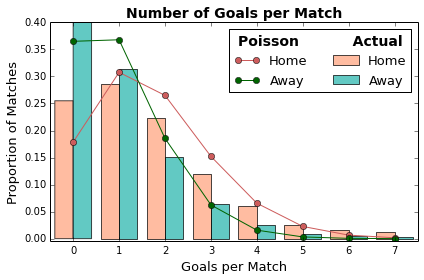

In [27]:
# Lets make a new dataframe only including when home is valid
home_df = my_wc.loc[my_wc['home_team'] == my_wc['country']]

# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, home_df.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(home_df[['home_score', 'away_score']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],normed=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

In [28]:
# probability of draw between home and away team
skellam.pmf(0.0,  home_df.mean()[0],  home_df.mean()[1])

0.23808802303598636

In [29]:
# probability of home team winning by one goal
skellam.pmf(1,  home_df.mean()[0],  home_df.mean()[1])

0.24243771381997845

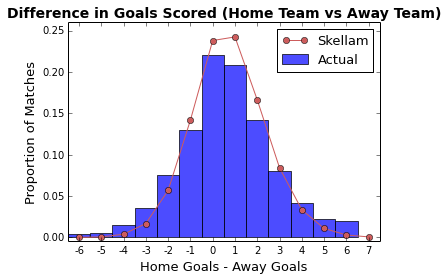

In [31]:
skellam_pred = [skellam.pmf(i,  home_df.mean()[0],  home_df.mean()[1]) for i in range(-6,8)]

plt.hist(home_df[['home_score']].values - home_df[['away_score']].values, range(-6,8), 
         alpha=0.7, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

## Format data for goal model

In [32]:
goal_model_data = pd.concat([my_wc[['home_team','away_team','home_score','rank_difference','home_home']].rename(
            columns={'home_team':'team', 'away_team':'opponent','home_score':'goals','home_home':'home'}),
           my_wc[['away_team','home_team','away_score','inv_diff','away_home']].rename(
            columns={'away_team':'team', 'home_team':'opponent','away_score':'goals','inv_diff':'rank_difference', 'away_home':'home'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent + rank_difference", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

goal_model_data.tail()

,team,opponent,goals,rank_difference,home
18454,Botswana,Zimbabwe,1,29.0,False
18465,Namibia,South Africa,1,35.0,False
18466,Botswana,Swaziland,2,11.0,False
18471,Madagascar,Zambia,0,36.0,False
18472,Zimbabwe,Lesotho,0,-37.0,False


In [33]:
poisson_model.predict(pd.DataFrame(data={'team': 'Portugal', 'opponent': 'Algeria',
                                       'home':False,'rank_difference':-62},index=[1]))

1    2.248
dtype: float64

In [34]:
poisson_model.predict(pd.DataFrame(data={'team': 'Algeria', 'opponent': 'Portugal',
                                       'home':False,'rank_difference':62},index=[1]))

1    0.475197
dtype: float64

In [35]:
def simulate_match(foot_model, homeTeam, awayTeam, rank_diff, home, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':home, 'rank_difference':rank_diff},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':False, 'rank_difference':-rank_diff},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
simulate_match(poisson_model, 'Portugal', 'Algeria', -62, False, max_goals=3)

array([[0.06566446, 0.03120355, 0.00741392, 0.00117436],
       [0.14761374, 0.0701456 , 0.01666649, 0.00263996],
       [0.16591787, 0.07884367, 0.01873314, 0.00296731],
       [0.12432782, 0.0590802 , 0.01403737, 0.0022235 ]])

In [36]:
port_alge = simulate_match(poisson_model, "Portugal", "Algeria", -62, 0, max_goals=10)
# Portugal win
np.sum(np.tril(port_alge, -1))

0.7797927212156873

In [37]:
# draw
np.sum(np.diag(port_alge))

0.15692169676431642

In [38]:
# Algeria win
np.sum(np.triu(port_alge, 1))

0.063261552647371

## 2018 World Cup Time!

### Load World Cup games database

In [135]:
# Loading new datasets
wc18 = pd.read_csv('./input/World Cup 2018 Dataset.csv') # Obtained from https://us.soccerway.com/teams/rankings/fifa/?ICID=TN_03_05_01

wc18 = wc18.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# List for storing the group stage games
pred_set = []

In [136]:
wc18.head()

,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Portugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


In [137]:
# Make function to get current ranking for team
def get_current_fifa_rank(team):
    int = wc18.loc[wc18['Team'] == str(team)]
    curr_rank = int.iloc[0]['Current \nFIFA rank']
    return curr_rank

# Simulate group stage

In [138]:
all_groups = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [144]:
def simulate_group(group):
    print "\nResults for Group: ", group
    teams = []
    points = {}
    not_rounded_tot_goals = {}
    
    group_df = wc18.loc[wc18['Group'] == group]
    
    # Get teams in group
    for i in range(4):
        team_name = group_df.iloc[i]['Team']
        teams.append(team_name)
        points[team_name] = 0.
        not_rounded_tot_goals[team_name] = 0.
        
    games = list(itertools.combinations(teams, 2))

    for idx, game in enumerate(games):
        team1 = game[0]
        rank1 = get_current_fifa_rank(team1)
        team2 = game[1]
        rank2 = get_current_fifa_rank(team2)

        rank_diff = rank1 - rank2

        home_flag = False
        if team1 == 'Russia':
            home_flag = True

        team1_goals = poisson_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2,
                                           'home':home_flag,'rank_difference':rank_diff},index=[1]))
        not_rounded_tot_goals[team1] += team1_goals.iloc[0]
        team1_goals = np.rint(team1_goals.iloc[0])

        home_flag = False
        if team2 == 'Russia':
            home_flag = True

        team2_goals = poisson_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1,
                                           'home':home_flag,'rank_difference':-rank_diff},index=[1]))
        not_rounded_tot_goals[team2] += team2_goals.iloc[0]
        team2_goals = np.rint(team2_goals.iloc[0])

        # Team1 wins
        if team1_goals > team2_goals:
            # 3 points to team 1
            points[team1] += 3.0
        elif team2_goals > team1_goals:
            points[team2] += 3.0
        else:
            points[team1] += 1.0
            points[team2] += 1.0

        print "Game #", idx
        print team1, " goals: ", team1_goals
        print team2, " goals: ", team2_goals

    print "\nGroup ", group, " Results"
    print points
    print "Not rounded total goals for tiebreaker"
    print not_rounded_tot_goals

In [145]:
for group in all_groups:
    simulate_group(group)


Results for Group:  A
Game # 0
Russia  goals:  2.0
Saudi Arabia  goals:  1.0
Game # 1
Russia  goals:  2.0
Egypt  goals:  1.0
Game # 2
Russia  goals:  1.0
Uruguay  goals:  1.0
Game # 3
Saudi Arabia  goals:  1.0
Egypt  goals:  1.0
Game # 4
Saudi Arabia  goals:  1.0
Uruguay  goals:  2.0
Game # 5
Egypt  goals:  1.0
Uruguay  goals:  1.0

Group  A  Results
{'Egypt': 2.0, 'Saudi Arabia': 1.0, 'Russia': 7.0, 'Uruguay': 5.0}
Not rounded total goals for tiebreaker
{'Egypt': 3.2481554532245904, 'Saudi Arabia': 2.2287090027719194, 'Russia': 5.05297518385399, 'Uruguay': 4.4826999687115325}

Results for Group:  B
Game # 0
Portugal  goals:  1.0
Spain  goals:  1.0
Game # 1
Portugal  goals:  2.0
Morocco  goals:  1.0
Game # 2
Portugal  goals:  1.0
Iran  goals:  1.0
Game # 3
Spain  goals:  2.0
Morocco  goals:  1.0
Game # 4
Spain  goals:  2.0
Iran  goals:  1.0
Game # 5
Morocco  goals:  1.0
Iran  goals:  1.0

Group  B  Results
{'Morocco': 1.0, 'Iran': 2.0, 'Spain': 7.0, 'Portugal': 5.0}
Not rounded total 

### Group Round Predictions

Results from the simulation of group rounds yield the following results

Group A:
1. Russia (7 pts)
2. Uruguay (5 pts)

Group B:
1. Spain (7 pts)
2. Portugal (5 pts)

Group C:
1. France (3 pts)
2. Denmark (3 pts)

Group D:
1. Argentina (7 pts)
2. Croatia (5 pts)

Group E:
1. Brazil (9 pts)
2. Switzerland (2 pts)

Group F:
1. Germany (7 pts)
2. Mexico (4 pts)

Group G:
1. England (7 pts)
2. Belgium (3 pts)

Group H:
1. Colombia (3 pts)
2. Poland (3 pts)

<img src="./predicted_knockout.png">

### How did we do?

14/16 Teams correct for the knockout round

### Mistakes:

Sweden not Germany

Japan not Poland

In [146]:
# Manually put in Round of 16 matches
rnd16_games = [('Russia', 'Portugal'), ('Spain', 'Uruguay'), 
              ('France', 'Croatia'), ('Argentina', 'Denmark'),
              ('Brazil', 'Mexico'), ('Germany', 'Switzerland'),
              ('England','Poland'), ('Colombia', 'Belgium')]

In [157]:
for game in rnd16_games:
    # Extract teams and rankings
    team1 = game[0]
    rank1 = get_current_fifa_rank(team1)
    team2 = game[1]
    rank2 = get_current_fifa_rank(team2)
    rank_diff = rank1 - rank2
    
    # Only give home field advantage to Russia
    home_field = (game[0] == 'Russia')
    
    game_sim = simulate_match(poisson_model, game[0], game[1], rank_diff, home_field, max_goals=10)
    # Portugal win
    team1_prob = np.sum(np.tril(game_sim, -1))
    draw_prob = np.sum(np.diag(game_sim))
    team2_prob = np.sum(np.triu(game_sim, 1))
    
    print "\nGame: ", game[0], " vs. ", game[1]
    print game[0], " win prob: ", team1_prob
    print game[1], " win prob: ", team2_prob
    print "Draw prob: ", draw_prob


Game:  Russia  vs.  Portugal
Russia  win prob:  0.25745322192355724
Portugal  win prob:  0.47840255373466917
Draw prob:  0.26414379569117025

Game:  Spain  vs.  Uruguay
Spain  win prob:  0.5326711916249969
Uruguay  win prob:  0.19740908415935038
Draw prob:  0.2699193582533825

Game:  France  vs.  Croatia
France  win prob:  0.40774111787191586
Croatia  win prob:  0.26338723403230807
Draw prob:  0.32887163616543424

Game:  Argentina  vs.  Denmark
Argentina  win prob:  0.4694209369314455
Denmark  win prob:  0.2547652939046023
Draw prob:  0.2758135466181396

Game:  Brazil  vs.  Mexico
Brazil  win prob:  0.6066185680875253
Mexico  win prob:  0.16924669580687157
Draw prob:  0.22413101232452742

Game:  Germany  vs.  Switzerland
Germany  win prob:  0.5218025727786133
Switzerland  win prob:  0.2227975069681
Draw prob:  0.25539914768025473

Game:  England  vs.  Poland
England  win prob:  0.5570011517989779
Poland  win prob:  0.17681407984666508
Draw prob:  0.26618432767189837

Game:  Colombia  

<img src="./predict_8.png">

In [158]:
# Rnd 8 games
rnd8_games = [('Portugal', 'France'), ('Brazil', 'England'),
             ('Spain', 'Argentina'), ('Germany', 'Colombia')]

for game in rnd8_games:
    # Extract teams and rankings
    team1 = game[0]
    rank1 = get_current_fifa_rank(team1)
    team2 = game[1]
    rank2 = get_current_fifa_rank(team2)
    rank_diff = rank1 - rank2
    
    # Only give home field advantage to Russia
    home_field = (game[0] == 'Russia')
    
    game_sim = simulate_match(poisson_model, game[0], game[1], rank_diff, home_field, max_goals=10)
    # Portugal win
    team1_prob = np.sum(np.tril(game_sim, -1))
    draw_prob = np.sum(np.diag(game_sim))
    team2_prob = np.sum(np.triu(game_sim, 1))
    
    print "\nGame: ", game[0], " vs. ", game[1]
    print game[0], " win prob: ", team1_prob
    print game[1], " win prob: ", team2_prob
    print "Draw prob: ", draw_prob


Game:  Portugal  vs.  France
Portugal  win prob:  0.3379943492656464
France  win prob:  0.33652539776867274
Draw prob:  0.3254802447495413

Game:  Brazil  vs.  England
Brazil  win prob:  0.4341932414453816
England  win prob:  0.2647968272206689
Draw prob:  0.3010098797004745

Game:  Spain  vs.  Argentina
Spain  win prob:  0.39941588308267456
Argentina  win prob:  0.3076613389227902
Draw prob:  0.29292272031942335

Game:  Germany  vs.  Colombia
Germany  win prob:  0.4224586356040815
Colombia  win prob:  0.28341172910689927
Draw prob:  0.29412957036917964


<img src="./predict_4.png">

In [159]:
# Semifinals
rnd4_games = [('Portugal', 'Brazil'), ('Spain', 'Germany')]

for game in rnd4_games:
    # Extract teams and rankings
    team1 = game[0]
    rank1 = get_current_fifa_rank(team1)
    team2 = game[1]
    rank2 = get_current_fifa_rank(team2)
    rank_diff = rank1 - rank2
    
    # Only give home field advantage to Russia
    home_field = (game[0] == 'Russia')
    
    game_sim = simulate_match(poisson_model, game[0], game[1], rank_diff, home_field, max_goals=10)
    # Portugal win
    team1_prob = np.sum(np.tril(game_sim, -1))
    draw_prob = np.sum(np.diag(game_sim))
    team2_prob = np.sum(np.triu(game_sim, 1))
    
    print "\nGame: ", game[0], " vs. ", game[1]
    print game[0], " win prob: ", team1_prob
    print game[1], " win prob: ", team2_prob
    print "Draw prob: ", draw_prob


Game:  Portugal  vs.  Brazil
Portugal  win prob:  0.2603080063850842
Brazil  win prob:  0.4606934814601461
Draw prob:  0.27899833188189704

Game:  Spain  vs.  Germany
Spain  win prob:  0.4347323523665218
Germany  win prob:  0.29157236672230613
Draw prob:  0.2736950787561864


<img src="./predict_final.png">

In [161]:
# Final Game
final_game = [('Brazil', 'Spain')]

for game in final_game:
    # Extract teams and rankings
    team1 = game[0]
    rank1 = get_current_fifa_rank(team1)
    team2 = game[1]
    rank2 = get_current_fifa_rank(team2)
    rank_diff = rank1 - rank2
    
    # Only give home field advantage to Russia
    home_field = (game[0] == 'Russia')
    
    game_sim = simulate_match(poisson_model, game[0], game[1], rank_diff, home_field, max_goals=10)
    # Portugal win
    team1_prob = np.sum(np.tril(game_sim, -1))
    draw_prob = np.sum(np.diag(game_sim))
    team2_prob = np.sum(np.triu(game_sim, 1))
    
    print "\nGame: ", game[0], " vs. ", game[1]
    print game[0], " win prob: ", team1_prob
    print game[1], " win prob: ", team2_prob
    print "Draw prob: ", draw_prob


Game:  Brazil  vs.  Spain
Brazil  win prob:  0.39085167142859417
Spain  win prob:  0.3218265661228167
Draw prob:  0.2873216891283484


# 2018 World Cup Winner: Brazil


<img src="./Brazil.png">